# Добавляем необходимые библиотеки:

In [1]:
pip install TensorFlow

Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from keras import layers
import logging
import numpy as np
import PIL.Image as Image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

CLASSIFIER_URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/classification/5"
IMAGE_RES = 224

# Загружаем MobileNet-модель и создаём из неё Keras-модель
model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])
model.summary()

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              4013897   
                                                                 
Total params: 4,013,897
Trainable params: 0
Non-trainable params: 4,013,897
_________________________________________________________________


# Генерируем обучающие и тестовую выборки:

In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,     # масштабирование значений пикселей
    shear_range=0.2,    # сдвиг изображения вдоль оси X
    zoom_range=0.2,     # масштабирование изображения
    rotation_range=10,  # поворот изображения на угол в градусах
    brightness_range=[0.5, 1.5],  # изменение яркости изображения
    horizontal_flip=False, # переворот изображения относительно горизонтальной оси
    vertical_flip=False)  # переворот изображения относительно вертикальной оси  

train_set = train_datagen.flow_from_directory(
    '/kaggle/input/berserk-heroes-train',   # путь к папке с обучающими изображениями
    target_size=(IMAGE_RES, IMAGE_RES),    # размер изображений
    batch_size=32,             # размер пакета (batch)
    class_mode='categorical')       # тип меток (binary или categorical)

Found 19256 images belonging to 193 classes.


In [4]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_set = validation_datagen.flow_from_directory(
    '/kaggle/input/berserk-heroes-validation',
    target_size=(IMAGE_RES, IMAGE_RES),
    batch_size=32,
    class_mode='categorical')

Found 446 images belonging to 193 classes.


# Загружаем модель:

In [5]:
from math import ceil

STEPS_PER_EPOCH = ceil(len(train_set.filenames) / 128)

# Использование learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*10,
  decay_rate=1,
  staircase=False)

In [6]:
fe_link = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5'
feature_extractor = hub.KerasLayer(fe_link, input_shape=(IMAGE_RES, IMAGE_RES, 3))

feature_extractor.trainable = False

model = tf.keras.Sequential([
        feature_extractor,
        # layers.BatchNormalization(),
        layers.Dense(193, activation='softmax'),
        # layers.Dropout(0.2)
      ])

model.compile(
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2731616   
                                                                 
 dense (Dense)               (None, 193)               247233    
                                                                 
Total params: 2,978,849
Trainable params: 247,233
Non-trainable params: 2,731,616
_________________________________________________________________


# Настраиваем обучение:

In [8]:
from keras.callbacks import EarlyStopping

early_stop =  EarlyStopping(
                              patience=10,
                              min_delta=0.001,                               
                              monitor="val_loss",
                              restore_best_weights=True
                              )


EPOCHS = 100

history = model.fit(train_set,
                    epochs=EPOCHS,
                    validation_data=validation_set, 
                    callbacks=[early_stop])

from tensorflow.keras.models import load_model

model.save_weights('Diplom-None.h5')

Epoch 1/100
602/602 [==============================] - 809s 1s/step - loss: 0.6651 - accuracy: 0.9317 - val_loss: 1.4171 - val_accuracy: 0.7466
Epoch 2/100
602/602 [==============================] - 746s 1s/step - loss: 0.0255 - accuracy: 0.9999 - val_loss: 1.2401 - val_accuracy: 0.7646
Epoch 3/100
602/602 [==============================] - 763s 1s/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 1.1775 - val_accuracy: 0.7758
Epoch 4/100
602/602 [==============================] - 760s 1s/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 1.1273 - val_accuracy: 0.7713
Epoch 5/100
602/602 [==============================] - 774s 1s/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.1027 - val_accuracy: 0.7780
Epoch 6/100
602/602 [==============================] - 773s 1s/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.0800 - val_accuracy: 0.7735
Epoch 7/100
602/602 [==============================] - 768s 1s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.0621 - val_accuracy:

In [9]:
# model.load_weights('diplom-2.h5')

# Графическое отображение результатов:

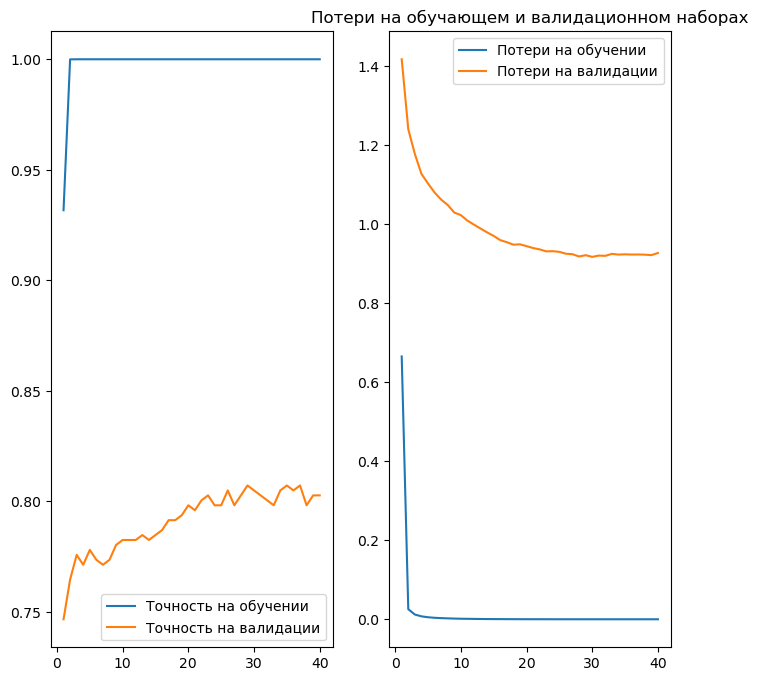

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучении')
plt.plot(epochs_range, val_acc, label='Точность на валидации')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на обучении')
plt.plot(epochs_range, val_loss, label='Потери на валидации')
plt.legend(loc='upper right')
plt.title('Потери на обучающем и валидационном наборах')
plt.show()

In [11]:
def data_generator(dataset, batch_size):
  i = 0
  while True:
    batch = dataset[i:i+batch_size]
    if not len(batch):
      break
    yield batch
    i += batch_size

batch_size = 10
val_data = data_generator(validation_set, batch_size)

In [12]:
class_names = np.array(list(validation_set.class_indices.keys()))

val_data = iter(validation_set)
image_batch, label_batch = next(val_data)

In [13]:
print('label_batch shape:', np.shape(label_batch))

label_batch shape: (32, 193)


In [14]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 1s 1s/step


array(['191 - Ликару', '161 - Серые мечники', '012 - Крылатая академия',
       '142 - Фальция Луна', '139 - Террор', '090 - Гвург',
       '150 - Иглошип', '055 - Спящий дракон', '103 - Побег',
       '052 - Ржавый дракон', '129 - Осквернить', '055 - Спящий дракон',
       '118 - Альп', '164 - Стражник Тугарда', '056 - Сфера эфира',
       '029 - Шипящий дракон', '181 - Адина', '108 - Сбить с толку',
       '130 - Остомант', '154 - Латы ужаса', '125 - Моровой дракон',
       '135 - Собиратель душ', '083 - Тилис', '147 - Всепоглощение',
       '038 - Гном-стрелок', '127 - Надих', '129 - Осквернить',
       '107 - Сагар', '047 - Прирученный дракон', '065 - Зов вожака',
       '178 - Атрос', '083 - Тилис'], dtype='<U25')

In [15]:
# преобразование матрицы предсказаний
predicted_ids = tf.one_hot(predicted_ids, 193)

In [16]:
# проверка размера матриц
print("Метки: ", label_batch.shape)
print("Предсказания: ", predicted_ids.shape)

Метки:  (32, 193)
Предсказания:  (32, 193)


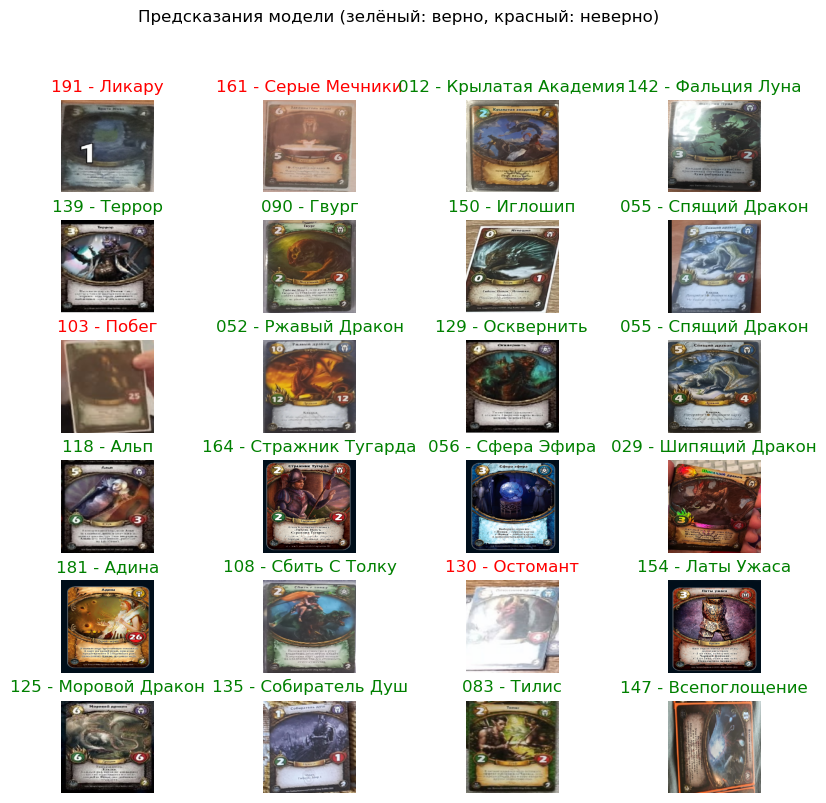

In [17]:
plt.figure(figsize=(10, 9))
for n in range(24):
  plt.subplot(6, 4, n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[n])
  color = "green" if np.array_equal(predicted_ids[n], label_batch[n]) else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Предсказания модели (зелёный: верно, красный: неверно)")

In [18]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to csv: 
history_csv = 'Diplom-None-History.csv'
with open(history_csv, mode='w') as f:
    hist_df.to_csv(f)

In [19]:
pd.read_csv('Diplom-None-History.csv')

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,0.665141,0.931710,1.417124,0.746637
1,1,0.025539,0.999948,1.240094,0.764574
2,2,0.012000,1.000000,1.177454,0.775785
3,3,0.007438,1.000000,1.127262,0.771300
4,4,0.005139,1.000000,1.102732,0.778027
5,5,0.003786,1.000000,1.080010,0.773543
6,6,0.002912,1.000000,1.062106,0.771300
7,7,0.002324,1.000000,1.048425,0.773543
8,8,0.001793,1.000000,1.029308,0.780269
9,9,0.001401,1.000000,1.022703,0.782511
